## 常见模式

### 1、批准或拒绝
中断最常用的用途之一是在执行关键操作前暂停并请求批准。例如，你可能需要请求人类批准 API 调用、数据库更改或任何其他重要决策。

In [1]:
from typing import Literal, Optional, TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt


class ApprovalState(TypedDict):
    action_details: str
    status: Optional[Literal["pending", "approved", "rejected"]]


def approval_node(state: ApprovalState) -> Command[Literal["proceed", "cancel"]]:
    # Expose details so the caller can render them in a UI
    decision = interrupt({
        "question": "Approve this action?",
        "details": state["action_details"],
    })

    # Route to the appropriate node after resume
    return Command(goto="proceed" if decision else "cancel")


def proceed_node(state: ApprovalState):
    return {"status": "approved"}


def cancel_node(state: ApprovalState):
    return {"status": "rejected"}


builder = StateGraph(ApprovalState)
builder.add_node("approval", approval_node)
builder.add_node("proceed", proceed_node)
builder.add_node("cancel", cancel_node)
builder.add_edge(START, "approval")
builder.add_edge("proceed", END)
builder.add_edge("cancel", END)

# Use a more durable checkpointer in production
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "approval-123"}}
initial = graph.invoke(
    {"action_details": "Transfer $500", "status": "pending"},
    config=config,
)
print(initial["__interrupt__"])  # -> [Interrupt(value={'question': ..., 'details': ...})]

# Resume with the decision; True routes to proceed, False to cancel
resumed = graph.invoke(Command(resume=True), config=config)
print(resumed["status"])  # -> "approved"

[Interrupt(value={'question': 'Approve this action?', 'details': 'Transfer $500'}, id='d0519eb2b1f96c45ecab61a56b4c48ed')]
approved


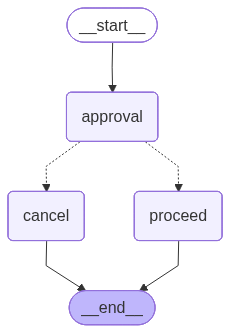

In [3]:
from IPython.display import Image, display

# Show the workflow
display(Image(graph.get_graph().draw_mermaid_png()))

### 2、审查和编辑 State

In [4]:
import sqlite3
from typing import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt


class ReviewState(TypedDict):
    generated_text: str


def review_node(state: ReviewState):
    # Ask a reviewer to edit the generated content
    updated = interrupt({
        "instruction": "Review and edit this content",
        "content": state["generated_text"],
    })
    return {"generated_text": updated}


builder = StateGraph(ReviewState)
builder.add_node("review", review_node)
builder.add_edge(START, "review")
builder.add_edge("review", END)

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "review-42"}}
initial = graph.invoke({"generated_text": "Initial draft"}, config=config)
print(initial["__interrupt__"])  # -> [Interrupt(value={'instruction': ..., 'content': ...})]

# Resume with the edited text from the reviewer
final_state = graph.invoke(
    Command(resume="Improved draft after review"),
    config=config,
)
print(final_state["generated_text"])  # -> "Improved draft after review"

[Interrupt(value={'instruction': 'Review and edit this content', 'content': 'Initial draft'}, id='114219ee95998136a16fc27650516cba')]
Improved draft after review


### 3、工具中断

您还可以直接在工具函数内部放置中断。这使工具本身在每次被调用时暂停以获得批准，并允许在执行之前对工具调用进行人类审查和编辑。

In [7]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

# 加载环境变量
load_dotenv(override=False)  # override=False 避免.env覆盖系统环境变量

model = ChatOpenAI(
    model=os.getenv("MODEL_NAME"),
    temperature=0.5,
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url=os.getenv("BASE_URL")
)

In [8]:
import sqlite3
from typing import TypedDict

from langchain.tools import tool
from langchain_anthropic import ChatAnthropic
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt


class AgentState(TypedDict):
    messages: list[dict]


@tool
def send_email(to: str, subject: str, body: str):
    """Send an email to a recipient."""

    # Pause before sending; payload surfaces in result["__interrupt__"]
    response = interrupt({
        "action": "send_email",
        "to": to,
        "subject": subject,
        "body": body,
        "message": "Approve sending this email?",
    })

    if response.get("action") == "approve":
        final_to = response.get("to", to)
        final_subject = response.get("subject", subject)
        final_body = response.get("body", body)

        # Actually send the email (your implementation here)
        print(f"[send_email] to={final_to} subject={final_subject} body={final_body}")
        return f"Email sent to {final_to}"

    return "Email cancelled by user"


# model = ChatAnthropic(model="claude-sonnet-4-5-20250929").bind_tools([send_email])


def agent_node(state: AgentState):
    # LLM may decide to call the tool; interrupt pauses before sending
    result = model.invoke(state["messages"])
    return {"messages": state["messages"] + [result]}


builder = StateGraph(AgentState)
builder.add_node("agent", agent_node)
builder.add_edge(START, "agent")
builder.add_edge("agent", END)

checkpointer = SqliteSaver(sqlite3.connect("tool-approval.db"))
graph = builder.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "email-workflow"}}
initial = graph.invoke(
    {
        "messages": [
            {"role": "user", "content": "Send an email to alice@example.com about the meeting"}
        ]
    },
    config=config,
)
print(initial["__interrupt__"])  # -> [Interrupt(value={'action': 'send_email', ...})]

# Resume with approval and optionally edited arguments
resumed = graph.invoke(
    Command(resume={"action": "approve", "subject": "Updated subject"}),
    config=config,
)
print(resumed["messages"][-1])  # -> Tool result returned by send_email

ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 20448 and this is thread id 13860.

### 4、验证人类输入
有时你需要验证来自人类的输入，并在输入无效时再次询问。你可以使用循环中的多个 interrupt 调用来实现这一点。


In [9]:
import sqlite3
from typing import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt


class FormState(TypedDict):
    age: int | None


def get_age_node(state: FormState):
    prompt = "What is your age?"

    while True:
        answer = interrupt(prompt)  # payload surfaces in result["__interrupt__"]

        if isinstance(answer, int) and answer > 0:
            return {"age": answer}

        prompt = f"'{answer}' is not a valid age. Please enter a positive number."


builder = StateGraph(FormState)
builder.add_node("collect_age", get_age_node)
builder.add_edge(START, "collect_age")
builder.add_edge("collect_age", END)

checkpointer = SqliteSaver(sqlite3.connect("forms.db"))
graph = builder.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "form-1"}}
first = graph.invoke({"age": None}, config=config)
print(first["__interrupt__"])  # -> [Interrupt(value='What is your age?', ...)]

# Provide invalid data; the node re-prompts
retry = graph.invoke(Command(resume="thirty"), config=config)
print(retry["__interrupt__"])  # -> [Interrupt(value="'thirty' is not a valid age...", ...)]

# Provide valid data; loop exits and state updates
final = graph.invoke(Command(resume=30), config=config)
print(final["age"])  # -> 30

ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 20448 and this is thread id 9300.

## 中断规则